# Imports and file loading

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import csv
import numpy as np
import resistive_pulse as rp

In [2]:
directory='/home/preston/Desktop/Science/Research/cancer_cells/data/Chip4_resistive_pulse/'
file_name='Chip4_HCT116_0021_0.005'

# Plot data to determine best parameters for event search

In [3]:
start=0
stop=10000000
data=rp.get_data_raw(directory+file_name, start, stop)

baseline_avg_length=200
trigger_sigma_threshold=6
baseline_history=np.empty((0,4))

index=0
while index+baseline_avg_length <= data.shape[0]:
    baseline=rp.get_baseline(data, index, baseline_avg_length, trigger_sigma_threshold)
    baseline_history=np.vstack((baseline_history, baseline))
    index+=baseline_avg_length

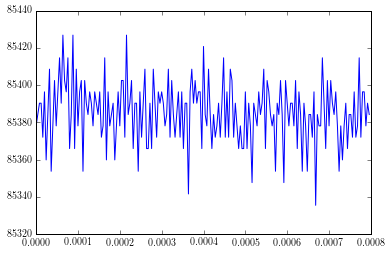

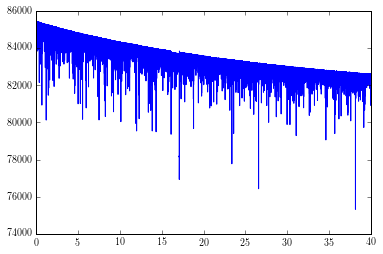

In [4]:
# Plot baseline over average length
plt.plot(data[:baseline_avg_length,0], data[:baseline_avg_length,1])
plt.show()

# Plot baseline
plt.plot(data[:,0], data[:,1], label='data')
plt.show()

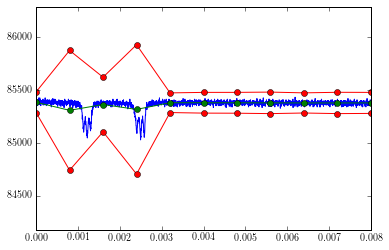

In [5]:
# Plot close up
a=0
b=2000
plt.plot(data[a:b,0], data[a:b,1])
plt.plot(baseline_history[:,0], baseline_history[:,1], '-o')
plt.plot(baseline_history[:,0], baseline_history[:,2], '-o', c = (1.,0,0))
plt.plot(baseline_history[:,0], baseline_history[:,3], '-o', c = (1.,0,0))
plt.xlim(data[a,0], data[b,0])
plt.ylim(0.99*data[a:b,1].min(), 1.01*data[a:b,1].max())
plt.show()

# Find events

In [6]:
events=rp.find_events_raw(directory+file_name)

starting segment: 0 / 12
error!
starting segment: 1 / 12
error!
starting segment: 2 / 12
error!
starting segment: 3 / 12
error!
starting segment: 4 / 12
error!
starting segment: 5 / 12
error!
starting segment: 6 / 12
error!
starting segment: 7 / 12
error!
starting segment: 8 / 12
error!
starting segment: 9 / 12
error!
starting segment: 10 / 12
error!
starting segment: 11 / 12
event # 1
	range =  731566 731567
event # 2
	range =  731623 731624
error!
starting segment: 12 / 12
event # 3
	range =  684680 684681
error!


# Post-process events

## Filter short events

In [4]:
length_threshold=50

events_length_before=len(events)
events=[event for event in events if event._data.shape[0] >= 50]
events_length_after=len(events)

print 'event length before:', events_length_before
print 'event length after:', events_length_after

event length before: 7
event length after: 7


## Find extrema

In [6]:
for event in events:
    maxima, minima=rp.get_maxima_minima(event._data[:,1], sigma=event._length/30., refine_length=3)
    event.set_extrema(maxima, minima)

before: [21, 44]
[5 0 1 2 6 3 4]
[6 3 1 0 4 5 2]
after: [22, 43]
before: [24, 46]
[6 1 0 5 3 2 4]
[6 1 0 4 3 5 2]
after: [25, 45]
before: [31, 51]
[6 3 0 2 5 1 4]
[6 2 5 0 1 4 3]
after: [32, 51]
before: [39, 64]
[0 1 6 3 5 2 4]
[0 3 5 6 1 2 4]
after: [40, 65]
before: []
after: []
before: [32, 51]
[0 2 5 6 4 1 3]
[5 0 6 2 3 1 4]
after: [32, 52]
before: [39, 63]
[1 0 2 4 3 6 5]
[0 5 6 2 1 3 4]
after: [41, 64]


### Refine extrema

### Remove non-conforming events

In [ ]:
events_length_before=len(events)
events=[event for event in events if len(event._extrema) == 5]
events_length_after=len(events)
print events_length_after, events_length_before

# Make plots

## Plot 100 events

0
1
2
3
4
5
6


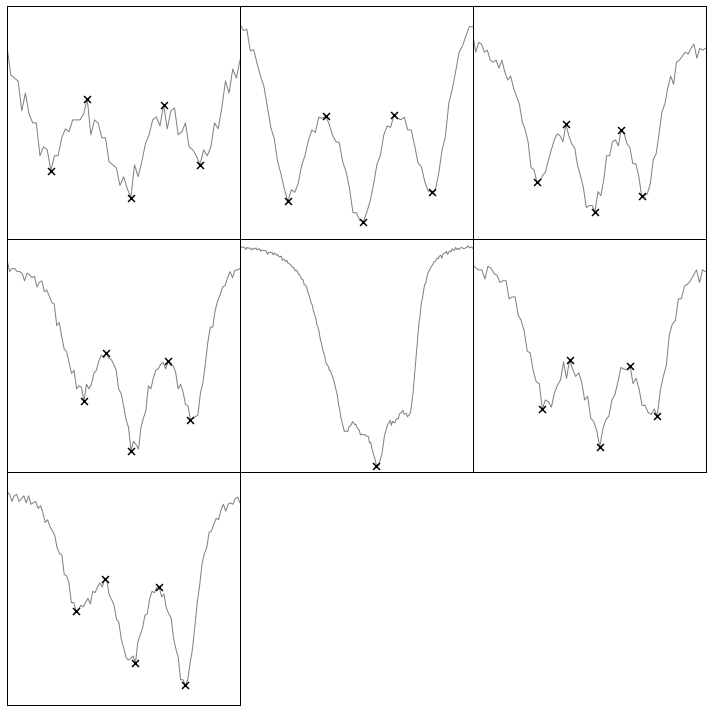

In [7]:
fig=plt.figure(figsize=(10,10))
gs=gridspec.GridSpec(3,3)
gs.update(wspace=0, hspace=0)
for i in range(7):
    plt.subplot(gs[i])
    f1=plt.gca()
    f1.axes.get_xaxis().set_ticks([])
    f1.axes.get_yaxis().set_ticks([])
    plt.plot(events[i]._data[:,0], events[i]._data[:,1], c=(128/255.,128/255.,128/255.))
    print i
    for j in range(len(events[i]._extrema)):
        extrema=events[i]._extrema[j]
        plt.scatter(events[i]._data[extrema,0], events[i]._data[extrema,1], c=(0,0,0), marker='x', s=48, lw=1.5, zorder=10)
        
    plt.xlim(events[i]._data[0,0], events[i]._data[-1,0])
    plt.ylim(0.999*events[i]._data[:,1].min(), 1.001*events[i]._data[:,1].max())
    
    plt.tick_params(
    axis='both',
    which='both',
    bottom='off',
    top='off',
    left='off',
    right='off',
    labelbottom='off',
    labelleft='off')
    
#plt.savefig('HCT-116_multievent.png', dpi=300)
fig.tight_layout()
plt.show()

## Histogram of peaks/anti-peaks

In [ ]:
p1_list=[]
p2_list=[]
p3_list=[]
p4_list=[]
p5_list=[]

for event in events:
    try:
        p1_list.append(event._data[event._minima[0],1]-event._data[0,1])
        p2_list.append(event._data[event._minima[1],1]-event._data[0,1])
        p3_list.append(event._data[event._minima[2],1]-event._data[0,1])
        p4_list.append(event._data[event._maxima[0],1]-event._data[0,1])
        p5_list.append(event._data[event._maxima[1],1]-event._data[0,1])
    except:
        continue

In [ ]:
import matplotlib.mlab as mlab

In [ ]:
xstart=0
xend=-6000

n, bins, patches=plt.hist(p1_list, 50, normed=0, alpha=0.2)
n, bins, patches=plt.hist(p2_list, 50, normed=0, alpha=0.2)
n, bins, patches=plt.hist(p3_list, 50, normed=0, alpha=0.2)
n, bins, patches=plt.hist(p4_list, 50, normed=0, alpha=0.2)
n, bins, patches=plt.hist(p5_list, 50, normed=0, alpha=0.2)
plt.xlim(xstart, xend)
plt.show()

## Plot Kernel density estimation of peaks/anti-peaks

In [ ]:
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

In [ ]:
p0_list=[]
p1_list=[]
p2_list=[]
p3_list=[]
p4_list=[]

for event in events:
    try:
        p0_list.append(event._baseline_avg-event._data[event._extrema[0],1])
        p1_list.append(event._baseline_avg-event._data[event._extrema[1],1])
        p2_list.append(event._baseline_avg-event._data[event._extrema[2],1])
        p3_list.append(event._baseline_avg-event._data[event._extrema[3],1])
        p4_list.append(event._baseline_avg-event._data[event._extrema[4],1])
        
    except:
        continue
        

p0_list=np.array(p0_list).reshape(-1,1)
p1_list=np.array(p1_list).reshape(-1,1)
p2_list=np.array(p2_list).reshape(-1,1)
p3_list=np.array(p3_list).reshape(-1,1)
p4_list=np.array(p4_list).reshape(-1,1)



xlow=0
xhigh=max(p0_list+p1_list+p2_list+p3_list+p4_list)
points=10000
xs=np.array([xlow+i*(xhigh-xlow)/points for i in range(points)]).reshape(-1,1)

In [ ]:
c=['blue','orange','green','red','magenta']

In [ ]:
rand_list=np.random.randint(low=0, high=len(events), size=100).tolist()

In [ ]:
title_size=24
axislabel_size=20
legendtitle_size=18
axistick_size=14
legendtext_size=16

In [ ]:
bandwidth=10.
fig=plt.figure(figsize=(10,10))

for i, p_list in enumerate([p0_list, p1_list, p2_list, p3_list, p4_list]):
    kde=KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(p_list)
    log_dens=kde.score_samples(xs)
    plt.plot(xs, np.exp(log_dens), c = c[i], label='extremum '+str(i))
    plt.fill(xs, np.exp(log_dens), fc=c[i], alpha=0.05)
    
    
    
p0_subset=[]
p1_subset=[]
p2_subset=[]
p3_subset=[]
p4_subset=[]
for i in rand_list:
    p0_subset.append(p0_list[i])
    p1_subset.append(p1_list[i])
    p2_subset.append(p2_list[i])
    p3_subset.append(p3_list[i])
    p4_subset.append(p4_list[i])
    
plt.plot(p0_subset,\
         np.zeros(len(p0_subset)) - 0.0005 + .0001*0, '+k', c = c[0])
plt.plot(p1_subset,\
         np.zeros(len(p1_subset)) - 0.0005 + .0001*1, '+k', c = c[1])
plt.plot(p2_subset,\
         np.zeros(len(p2_subset)) - 0.0005 + .0001*2, '+k', c = c[2])
plt.plot(p3_subset,\
         np.zeros(len(p3_subset)) - 0.0005 + .0001*3, '+k', c = c[3])
plt.plot(p4_subset,\
         np.zeros(len(p4_subset)) - 0.0005 + .0001*4, '+k', c = c[4])
    
plt.xlim(0, 1000)
plt.ylim(-.0006, .025)

plt.tick_params(axis='both', which='major', labelsize=axistick_size)
plt.tick_params(axis='both', which='minor', labelsize=axistick_size)

plt.title('extremum amplitude distributions', size=title_size)
plt.ylabel('probability', size=axislabel_size)
plt.xlabel(r'amplitude ($\mu$A)', size=axislabel_size)
plt.legend(loc='upper right', fontsize=legend_size)
plt.savefig('20um_peak_distributions.png', dpi=300)
plt.show()

# Peak fractions

### HCT-116:
    - Chip4_HCT116_0021_0.005
        - [0.83828975348756851, 0.49879334818146326, 1.0, 0.50353118248220341, 0.90134808144913603] [0.18673415792198006, 0.091534369666284268, 0.0, 0.090690073463094087, 0.18754554732119016] (avg, std)
        
### 20 um:
    - Chip4_20um_100mM_KCl_pH8_01_flow_0010
        [0.90599419910237966, 0.4902045203483148, 1.0, 0.46972675833364119, 0.87382647062521845] [0.03673276809944926, 0.043835395872859909, 0.0, 0.040748840779426837, 0.030427783064074877]  

In [ ]:
peak_fraction_list=[]
peak_fraction_avg=[0 for i in range(5)]
peak_fraction_std=[0 for i in range(5)]
for j in range(0,5):
    peak_fraction_list=[]
    for i in range(len(events)):
        event=events[i]
        pt0=event._data[event._extrema[j],1]-event._baseline_avg
        pt1=event._data[event._extrema[2],1]-event._baseline_avg
        peak_fraction_list.append(1.*pt0/pt1)
        
    peak_fraction_avg[j]=np.array(peak_fraction_list).mean()
    peak_fraction_std[j]=np.array(peak_fraction_list).std()

In [ ]:
print peak_fraction_avg, peak_fraction_std

In [ ]:
hct_avg=[.838, .499, 1.00, .504, .901]
hct_std=[0.187, 0.092, 0.00, 0.091, 0.188]
p20um_avg=[.906, .490, 1.00, .470, .874]
p20um_std=[0.037, 0.044, 0.00, 0.041, 0.030]

In [ ]:
fig=plt.figure(figsize=(8,6))

plt.errorbar([i for i in range(5)], hct_avg, yerr=hct_std, c=(1,0,0), fmt='o', label='HCT-116')
plt.errorbar([i for i in range(5)], p20um_avg, yerr=p20um_std, c=(0,0,1), fmt='o', label=r'20 um sphere')

plt.xlim(-1,5)
plt.ylim(0.2,1.2)

plt.title('Average fractional amplitude of peak', size=title_size)
plt.legend(loc='lower left', numpoints=1, fontsize=legendtext_size)
plt.xlabel('Peak', size=axislabel_size)
plt.ylabel('Fraction', size=axislabel_size)

plt.savefig('peak_fractions.png', dpi=300)

plt.show()

In [ ]:
peak_fraction_list=[]
peak_fraction_avg=[0 for i in range(5)]
peak_fraction_std=[0 for i in range(5)]
peak_fraction_list=[]
for i in range(len(events)):
    event=events[i]        
    pt0=event._data[event._extrema[0],1]-event._baseline_avg
    pt1=event._data[event._extrema[2],1]-event._baseline_avg
    peak_fraction_list.append(1.*pt0/pt1)
        
plt.plot(peak_fraction_list)
plt.show()

In [ ]:
for i in range(0,1):
    print 'asdf'

In [8]:
np.argsort(np.array([3,2,1]))

array([2, 1, 0])